<a href="https://colab.research.google.com/github/Dev00-1/Smile-Detection-/blob/main/Smile_Dectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving labels_my-project-name_2025-07-11-06-55-42.zip to labels_my-project-name_2025-07-11-06-55-42.zip


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2025-05-24 180110.png to Screenshot 2025-05-24 180110 (1).png
Saving Screenshot_20250615-192524~2.png to Screenshot_20250615-192524~2 (1).png
Saving Screenshot_20250615-192528~2.png to Screenshot_20250615-192528~2 (1).png
Saving Screenshot_20250615-192602~2.png to Screenshot_20250615-192602~2 (1).png


In [ ]:
import zipfile

with zipfile.ZipFile("labels_my-project-name_2025-07-11-06-55-42.zip", 'r') as zip_ref:
  zip_ref.extractall("annotations")

print("✅ Annotations extracted!")


✅ Annotations extracted!


In [ ]:
import os

print("Annotation files:", os.listdir('annotations'))
print("Images files:", os.listdir())

Annotation files: ['Screenshot_20250615-192602~2.xml', 'Screenshot 2025-05-24 180110.xml', 'Screenshot_20250615-192528~2.xml', 'Screenshot_20250615-192524~2.xml']
Images files: ['.config', 'Screenshot_20250615-192602~2.png', 'Screenshot 2025-05-24 180110 (1).png', 'Screenshot_20250615-192524~2 (1).png', 'labels_my-project-name_2025-07-11-06-55-42.zip', 'Screenshot_20250615-192528~2.png', 'Screenshot_20250615-192602~2 (1).png', 'Screenshot_20250615-192528~2 (1).png', 'Screenshot_20250615-192524~2.png', 'Screenshot 2025-05-24 180110.png', 'annotations', 'sample_data']


In [ ]:
import xml.etree.ElementTree as ET

def parse_xml_annotation(xml_path):
  tree = ET.parse(xml_path)
  root = tree.getroot()
  bboxes = []
  for obj in root.findall('object'):
    name = obj.find('name').text
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    bboxes.append({'label': name, 'bbox': [xmin, ymin, xmax, ymax]})
    return bboxes

print(parse_xml_annotation('annotations/Screenshot 2025-05-24 180110.xml'))


[{'label': 'dog-smile-1', 'bbox': [178, 182, 443, 329]}]


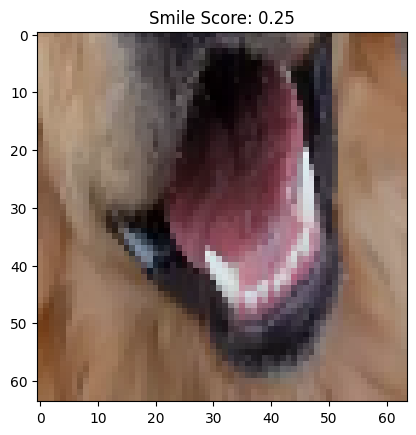

In [ ]:
import cv2
import matplotlib.pyplot as plt

def crop_bbox_and_score(image_path, bboxes):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    crops = []
    for box in bboxes:
        xmin, ymin, xmax, ymax = box['bbox']
        cropped = img[ymin:ymax, xmin:xmax]
        resized = cv2.resize(cropped, (64, 64))

        # Smile score based on label
        if 'dog-smile-1' in box['label']:
            score = 0.25
        elif 'dog-smile-2' in box['label']:
            score = 0.5
        elif 'dog-smile-3' in box['label']:
            score = 0.75
        elif 'dog-smile-4' in box['label']:
            score = 1.0
        else:
            score = 0.0

        crops.append((resized, score))
    return crops

# Test karo ek example
bboxes = parse_xml_annotation('annotations/Screenshot 2025-05-24 180110.xml')
cropped = crop_bbox_and_score('Screenshot 2025-05-24 180110.png', bboxes)

# Dekho kaise dikhta hai
plt.imshow(cropped[0][0])
plt.title(f"Smile Score: {cropped[0][1]}")
plt.show()

In [ ]:
import numpy as np

X = []
y = []

# Loop for all XML files
for file in os.listdir('annotations'):
    if file.endswith('.xml'):
        image_file = file.replace('.xml', '.png')
        if image_file in os.listdir():
            bboxes = parse_xml_annotation(f'annotations/{file}')
            crops = crop_bbox_and_score(image_file, bboxes)
            for img, score in crops:
                X.append(img / 255.0)  # Normalize
                y.append(score)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(4, 64, 64, 3) (4,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

history = model.fit(X, y, epochs=20, batch_size=2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,337 (3.14 MB)

 Trainable params: 822,337 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 2.7682 - mae: 1.4501
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3263 - mae: 0.5321
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9337 - mae: 0.9011
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5089 - mae: 0.6626
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2217 - mae: 0.4174
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1412 - mae: 0.2993
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1410 - mae: 0.3145
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0677 - mae: 0.2312 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0516 - mae: 0.2016 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0473 - mae: 0.1924
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0444 - mae: 0.1848 
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0300 - mae: 0.1401
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 

In [ ]:
test_img = X[0].reshape(1, 64, 64, 3)
pred = model.predict(test_img)
print("Predicted Smile Score:", pred)

model.save('dog_smile_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Smile Score: [[1.0182699]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


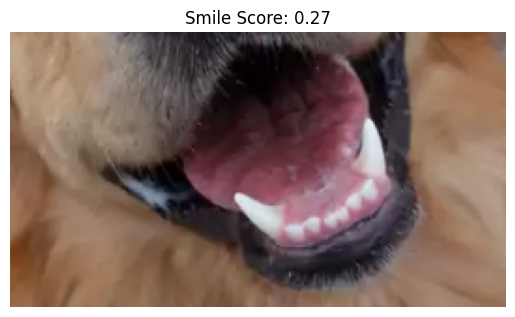

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Example: Ek hi image ka crop + score dekhna
img_path = 'Screenshot 2025-05-24 180110.png'
annotation_path = 'annotations/Screenshot 2025-05-24 180110.xml'

# Parse the XML (agar pehle se function hai)
bboxes = parse_xml_annotation(annotation_path)

# Load original image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Loop through bboxes
for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox['bbox']
    cropped = img[ymin:ymax, xmin:xmax]
    resized = cv2.resize(cropped, (64, 64)) / 255.0
    input_img = np.expand_dims(resized, axis=0)
    smile_score = model.predict(input_img)[0][0]

    # Show crop + score
    plt.imshow(cropped)
    plt.title(f'Smile Score: {smile_score:.2f}')
    plt.axis('off')
    plt.show()

In [ ]:
# Ek image ka example
bboxes = [
    {
        'label': 'dog-smile-1',
        'bbox': [178, 182, 443, 329]  # xmin, ymin, xmax, ymax
    }
]

# Sabhi images ke liye:
all_bboxes = {
    'Screenshot 2025-05-24 180110.png': [
        {'label': 'dog-smile-1', 'bbox': [178, 182, 443, 329]}
    ],
    'Screenshot_20250615-1925242.png': [
        {'label': 'dog-smile-2', 'bbox': [xmin, ymin, xmax, ymax]}
    ],
    # aur bhi add karo...
}

# Example:
bboxes = all_bboxes['Screenshot 2025-05-24 180110.png']
print(bboxes)

[{'label': 'dog-smile-1', 'bbox': [178, 182, 443, 329]}]
